In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def list_str2float(x):
    return list(map(float, x.replace('[','').replace(']','').split(',')))

def accepted_h0(pvals, alpha):
    return np.mean(np.array(list_str2float(pvals)) > alpha)

## Power as heat maps

In [3]:
def get_tt_power(df, true_distrib, alter_distrib, alpha):
    # find critial value of KS statistic
    df_filtred = df[(df['true_dist'] == true_distrib) & (df['alter_dist'] == alter_distrib)]
    try:
        return 1 - accepted_h0(df_filtred.pvals.values[0], alpha)
    except:
        return np.nan

def plot_power_matrix_tt(df, label, alpha=0.05, output_to_file=True):
    dists = df.true_dist.unique()
    n_dist = len(dists)
    values = np.zeros((n_dist, n_dist))
    avg_power = []
    signif = []
    for id_td, td in enumerate(dists):
        for id_ad, ad in enumerate(dists):
            values[id_td, id_ad] = np.nan = get_tt_power(df, td, ad, alpha)
            if td != ad:
                avg_power.append(values[id_td, id_ad])
            else:
                signif.append(values[id_td, id_ad])
    avg_power = np.nanmean(avg_power)
    initial_fig_size = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(values)
    plt.xticks(ticks=range(len(dists)), labels=dists, rotation=90)
    plt.yticks(range(len(dists)), labels=dists)
    plt.xlabel('ALTER Distribution')
    plt.ylabel('TRUE Distribution')
    plt.title(f'{label} \n Average Power: {avg_power:.4f}', fontsize=14)
    c = plt.colorbar()
    plt.clim(0, 1)
    if output_to_file:
        plt.savefig(f'plots/1sample_{label.replace(" ", "_")}.pdf', bbox_inches='tight')
    else:
        plt.show()
    plt.rcParams['figure.figsize'] = initial_fig_size
    plt.clf()

def get_ks_power(df, true_distrib, alter_distrib, alpha):
    # find critial value of KS statistic
    df_filtred = df[(df['true_dist'] == true_distrib) & (df['alter_dist'] == true_distrib)]
    try:
        D = np.quantile(list_str2float(df_filtred.dks.values[0]), 1-alpha)
    except:
        return np.nan
    df_filtred = df[(df['true_dist'] == true_distrib) & (df['alter_dist'] == alter_distrib)]
    try:
        return 1 - np.mean(list_str2float(df_filtred.dks.values[0]) < D)
    except:
        return np.nan

def plot_power_matrix_ks(df, label, alpha=0.05, output_to_file=True):
    dists = df.alter_dist.unique()
    n_dist = len(dists)
    values = np.zeros((n_dist, n_dist))
    avg_power = []
    signif = []
    for id_td, td in enumerate(dists):
        for id_ad, ad in enumerate(dists):
            values[id_td, id_ad] = get_ks_power(df, td, ad, alpha)
            if td != ad:
                avg_power.append(values[id_td, id_ad])
            else:
                signif.append(values[id_td, id_ad])
    avg_power = np.nanmean(avg_power)
    initial_fig_size = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(values)
    plt.xticks(ticks=range(len(dists)), labels=dists, rotation=90)
    plt.yticks(range(len(dists)), labels=dists)
    plt.xlabel('ALTER Distribution')
    plt.ylabel('TRUE Distribution')
    plt.title(f'{label} \n Average Power: {avg_power:.4f}', fontsize=14)
    c = plt.colorbar()
    plt.clim(0, 1)
    if output_to_file:
        plt.savefig(f'plots/1sample_{label.replace(" ", "_")}.pdf', bbox_inches='tight')
    else:
        plt.show()
    plt.rcParams['figure.figsize'] = initial_fig_size
    plt.clf()    

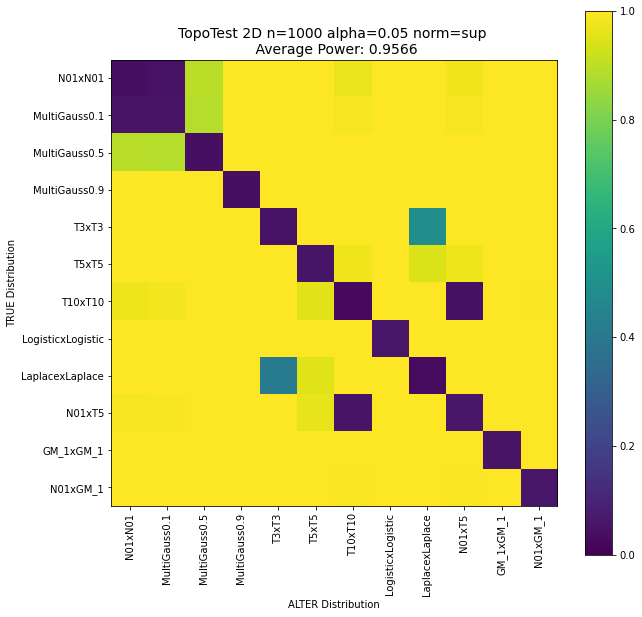

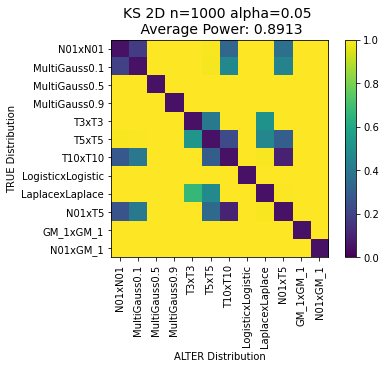

<Figure size 432x288 with 0 Axes>

In [4]:
# make one plot to see how it works
dim=2
n=1000
alpha=0.05
norm='sup'
df_tt = pd.read_csv(f'../results/dim={dim}_n={n}_norm={norm}_method=approximate.csv')
plot_power_matrix_tt(df_tt, label=f'TopoTest {dim}D n={n} alpha={alpha} norm={norm}', alpha=alpha,
                    output_to_file=False)

df_ks = pd.read_csv(f'../results/ks_dim={dim}_n={n}.csv')
plot_power_matrix_ks(df_ks, label=f'KS {dim}D n={n} alpha={alpha}', alpha=alpha,
                    output_to_file=False)

In [5]:
dims = [1, 2, 3]
ns=[100, 250, 500, 1000, 2500]
alpha=0.05
norm='sup'
for dim in dims:
    for n in ns:
        df_tt = pd.read_csv(f'../results/dim={dim}_n={n}_norm={norm}_method=approximate.csv')
        plot_power_matrix_tt(df_tt, label=f'TopoTest {dim}D n={n} alpha={alpha} norm={norm}', alpha=alpha,
                            output_to_file=True)

        df_ks = pd.read_csv(f'../results/ks_dim={dim}_n={n}.csv')
        plot_power_matrix_ks(df_ks, label=f'KS {dim}D n={n} alpha={alpha}', alpha=alpha,
                            output_to_file=True)

<Figure size 720x720 with 0 Axes>

## Mean Power

In [6]:
def mean_power(df, alpha, mode='tt'):
    dists = df.alter_dist.unique()
    n_dist = len(dists)
    avg_power = []
    signif = []
    for id_td, td in enumerate(dists):
        for id_ad, ad in enumerate(dists):
            if mode =='tt':
                val = get_tt_power(df, td, ad, alpha)
            else:
                val = get_ks_power(df, td, ad, alpha)
            if td != ad:
                avg_power.append(val)
            else:
                signif.append(val)
    return np.nanmean(avg_power)

In [7]:
dims = [1, 2, 3, 5]
alpha = 0.05
ns=[100, 250, 500, 1000, 2500, 5000]
norm = 'sup'

plot_ks = True

for dim in dims:
    power_tt = []
    power_ks = []
    for n in ns:
        try:
            df_tt = pd.read_csv(f'../results/dim={dim}_n={n}_norm={norm}_method=approximate.csv')
            power_tt.append(mean_power(df_tt, alpha=alpha, mode='tt'))
        except:
            power_tt.append(np.nan)
        try:
            df_ks = pd.read_csv(f'../results/ks_dim={dim}_n={n}.csv')
            power_ks.append(mean_power(df_ks, alpha=alpha, mode='ks'))
        except:
            power_ks.append(np.nan)

    initial_fig_size = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = [7, 4.5]
    plt.plot(ns, power_tt, 'o-', label='TopoTest')
    if plot_ks:
        plt.plot(ns, power_ks, 'o-', label='KS')
    plt.xlabel('Sample size, n')
    plt.ylabel('Average power')
    plt.title(f'Average power, dim={dim}')
    plt.legend()
    plt.grid()
    plt.savefig(f'plots/1sample_power_n_dim={dim}.pdf', bbox_inches='tight')
    plt.rcParams['figure.figsize'] = initial_fig_size
    plt.clf()

<Figure size 504x324 with 0 Axes>